In [4]:
# IMPORT
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(1,'/Users/jackh/Documents/FMBV_2023/gordon_original/src/') # FMBV src
sys.path.insert(1,'/Users/jackh/Documents/FMBV_2023/gordon_original/visualisation/') # FMBV src


import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import random
import fmbv_refactor
from scipy.ndimage.filters import gaussian_filter

/var/folders/9v/f6c01sn97rb6v_y68jr4gcn80000gn/T/ipykernel_12791/782162276.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [5]:
bottom = 1

In [6]:
# CONSTRUCT IMAGE

''' 
Since we need distance information, for simplicity I will take an existing
.vol case and essentially overwrite the voxel information since the algorithm 
is already set up for obtaining distance information from .vol files.
'''

# Initial Files
initial_kretz = '/Users/jackh/Documents/FMBV_2023/gordon_original/test_batch/wl1_4.vol'
initial_pd = '/Users/jackh/Documents/FMBV_2023/gordon_original/test_batch/wl1_4_dp.nii.gz'
initial_seg = '/Users/jackh/Documents/FMBV_2023/gordon_original/test_batch/wl1_4_seg.nii.gz'


pd_img = sitk.ReadImage(initial_pd)
seg_img = sitk.ReadImage(initial_seg)
pd_array = sitk.GetArrayFromImage(pd_img)
array_shape = pd_array.shape

sweep_region = pd_array>0

# plt.imshow(sweep_region[:,100,:])

pd_array = np.zeros(array_shape)+bottom*np.random.random(array_shape)*sweep_region
seg_array = np.zeros(array_shape)


In [7]:
def horizontal_vessel(point, y = 0, z = 0, r = 50):
    tmp = np.sqrt((point[1] - y)**2 + (point[0] - z)**2)
    if tmp <= r:
        return True
    else:
        return False

In [8]:
f = fmbv_refactor.FMBV()
f.load_pd(initial_pd)
f.load_kretz(initial_kretz)
dist = f.get_distance_map()

min_dist = np.min(dist)
max_dist = np.max(dist)

def att_coeff(d, d_interval, val_interval, att=True):
    min_dist = d_interval[0]
    max_dist = d_interval[1]

    a = val_interval[0]
    b = val_interval[1]
    
    if att:
        return a + (d - min_dist)/(max_dist - min_dist) * (b - a)
    else:
        return 1

In [9]:
OFFSET = 20

for i in range(array_shape[0]):
    # This loop approximately varies the depth
    
    # r_art = 20
    # r_art = 20 + 50*np.sin(2*np.pi*i/array_shape[0])**2 # "artery radius"
    # r_art = 10 + 60*i/array_shape[0]

    for j in range(array_shape[1]):
        for k in range(array_shape[2]):
            pd_array[i,j,k] = pd_array[i,j,k] +  int(
                200*horizontal_vessel(np.array([i,j,k]),
                y=int(.5*pd_array.shape[1]),
                z=int(.5*pd_array.shape[0])-OFFSET,
                r=9
                )*att_coeff(dist[i,j,k], [min_dist, max_dist], [1, 0.7], att=True)
            )

            pd_array[i,j,k] = pd_array[i,j,k] +  int(
                150*horizontal_vessel(np.array([i,j,k]),
                y=int(.5*pd_array.shape[1]),
                z=int(.5*pd_array.shape[0])+OFFSET,
                r=9
                )*att_coeff(dist[i,j,k], [min_dist, max_dist], [1, 0.7], att=True)
            )

            # seg_array[i,j,k] = 1*sphere(np.array([i,j,k]), r = 50)
            seg_array[i,j,k] = sweep_region[i,j,k]

pd_array = gaussian_filter(pd_array, sigma=1)

In [10]:
# add noise and clean
for i in range(array_shape[0]):
    for j in range(array_shape[1]):
        for k in range(array_shape[2]):

            if sweep_region[i,j,k]==1:
                noise = np.abs(np.random.normal(loc=0.0, scale=8))
                pd_array[i,j,k] = pd_array[i,j,k] + noise
            else:
                pd_array[i,j,k] = 0

            # pd_array[i,j,k] = int(pd_array[i,j,k])



In [11]:
# pd_array.shape

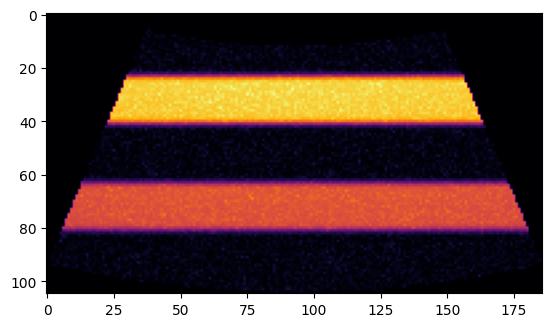

In [12]:
plt.imshow(pd_array[:,int(.5*pd_array.shape[1]),:], cmap='inferno')

pd_slice = pd_array[:,int(.5*pd_array.shape[1]),:]

In [13]:
case_name = "two_artery_example"

if not os.path.isdir(case_name):
    os.makedirs(case_name)

shutil.copy(initial_kretz, case_name+'/'+case_name+'.vol')

PD_PATH = case_name+'/'+case_name+'_dp.nii.gz'
SEG_PATH = case_name+'/'+case_name+'_seg.nii.gz'

result_pd_img = sitk.GetImageFromArray(pd_array)
result_pd_img.CopyInformation(pd_img)
sitk.WriteImage(result_pd_img, PD_PATH)

result_seg_img = sitk.GetImageFromArray(seg_array)
result_seg_img.CopyInformation(seg_img)
sitk.WriteImage(result_seg_img, SEG_PATH)


In [14]:
# g = fmbv_refactor.FMBV()
# g.load_pd(PD_PATH)
# g.load_kretz(initial_kretz)
# g.load_seg(SEG_PATH)

# g.global_method()

In [15]:
# dat = g.global_figdata_std_1

# print(dat.keys())

# plt.plot(dat['x'], dat['y_cumsum'])

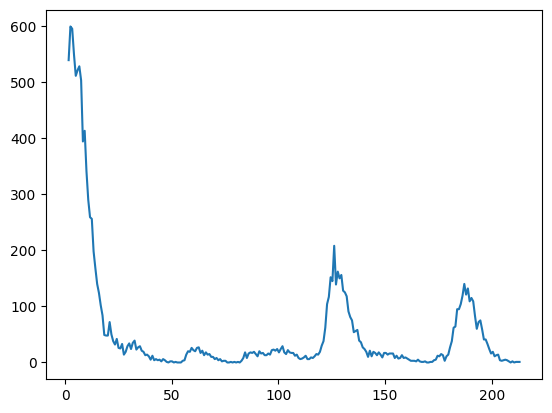

In [16]:
x, y = np.histogram(pd_slice.flatten(), bins=255)

plt.plot(y[2:], x[1:])

Text(0.5, 1.0, 'Power Doppler Cumulative Distribution')

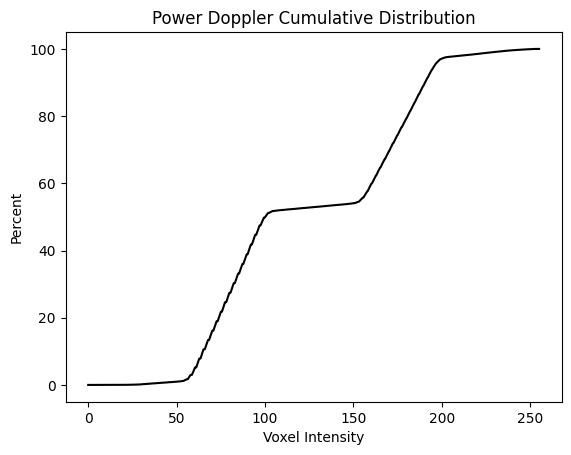

In [17]:
cumsum = np.cumsum(pd_slice.flatten())

x = 255*np.array(range(len(cumsum)))/len(cumsum)

plt.figure()

plt.plot(x,100*cumsum/np.max(cumsum), c='k')
plt.xlabel("Voxel Intensity")
plt.ylabel("Percent")
plt.title("Power Doppler Cumulative Distribution")

In [32]:
import sys
import networkx as nx
sys.path.insert(1,'./../../src')
import methods
from scipy import ndimage

img_array = ndimage.zoom(pd_slice, 1)
# img_array = pd_array
mask_array = img_array > 0

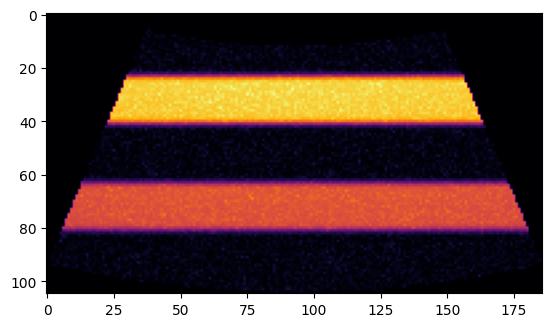

In [33]:
plt.imshow(img_array, cmap='inferno')

In [28]:
# create graph

wf = methods.WeightKernel(
    dist_sig = 1,
    intensity_sig = 20
)

# problem with mask?
G = methods.ImageGraph(
    img_array, 
    mask_array=mask_array, 
    wf=wf, 
    neighbour_depth = 1, 
    cmap='inferno'
    )

In [29]:
nx.write_gexf(G,'two_artery_gexf.gexf')